# Notebook for building cages from Andrew Marsh precursors

Distributed under the terms of the MIT License.

Author: Andrew Tarzia

Date Created: 22 Feb 2019


In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
import glob
import stk
import pywindow as pw
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ase.visualize import view
from ase.io import read

In [2]:
precursor_dir = '/home/atarzia/projects/andrew_marsh_structures/precursor_lib/'
output_dir = '/home/atarzia/projects/andrew_marsh_structures/output/'
macromod_ = '/home/atarzia/software/schrodinger_install'
# '/rds/general/user/fszczypi/home/schrodinger2018-4'
big_DB = '/data/atarzia/precursor_DBs/reaxys_sorted/'
aldehydes2f = big_DB+'aldehydes2f/'
print(len(glob.glob(aldehydes2f+'*mol')), 'precusrors in', aldehydes2f)
aldehydes3f = big_DB+'aldehydes3f/'
print(len(glob.glob(aldehydes3f+'*mol')), 'precusrors in', aldehydes3f)
amines2f = big_DB+'amines2f/'
print(len(glob.glob(amines2f+'*mol')), 'precusrors in', amines2f)
amines3f = big_DB+'amines3f/'
print(len(glob.glob(amines3f+'*mol')), 'precusrors in', amines3f)

280 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/aldehydes2f/
63 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/aldehydes3f/
507 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/amines2f/
90 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/amines3f/


In [3]:
# synthetic accessibility DBs
amines2f_SA = pd.read_csv(amines2f+'score_output_amines2f.csv')
amines3f_SA = pd.read_csv(amines3f+'score_output_amines3f.csv')

In [4]:
precursor_files = sorted(glob.glob(precursor_dir+'*.mol'))
precursor_names = [i.replace(precursor_dir, '') for i in precursor_files]
precursor_struc = [stk.StructUnit3(i) for i in precursor_files]  # read in mol files

## Aldehyde 1

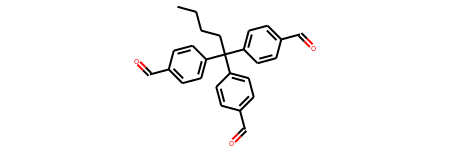

In [5]:
Chem.MolFromInchi(precursor_struc[0].inchi)

## Aldehyde 2

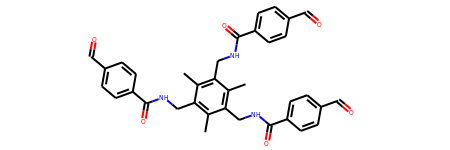

In [6]:
Chem.MolFromInchi(precursor_struc[1].inchi)

## Aldehyde 3

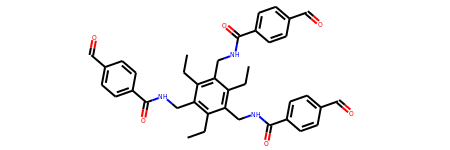

In [7]:
Chem.MolFromInchi(precursor_struc[2].inchi)

## Aldehyde 4

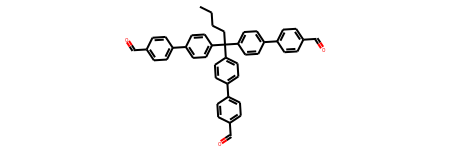

In [8]:
Chem.MolFromInchi(precursor_struc[3].inchi)

# Brute force production of cages
- for all 4 precursors
- all possible topologies (3aldehdye+2amine)
- all possible topologies (3aldehdye+3amine)
- macromodel optimization will determine if collapsed
- run full pywindow analysis
    - output properties
- read pywindow results
    - produce CSV: BB-aldehyde, BB-amine, collapsed?, ....

In [9]:
def is_collapse(topo, avg_diff, max_window_diam, cavity_size, no_window):
    e_wind = {'dodec': 12, '4p6': 4, '4p62': 4,
              '8p12': 6,  '6p9': 5, '2p3': 3, 
              '4p4': 6, '1p1': 3, '2p2': 4}
    expected_wind = e_wind[topo]
    if expected_wind == no_window:
        alpha = 4 * avg_diff / (max_window_diam * expected_wind)
        if alpha < 0.035 and cavity_size > 1:
            # not collapsed
            return False
        else:
            # unknown
            return None
    else:
        # collapsed
        return True
    

def get_assymmetry(data):
    """Calculate assymetry as defined in GA paper (Berardo)
    
    The sum of all the windows' pair differences represents the asymmetry of the individual, Asymmetry parameter in eqn (1)
    """
    window_sizes = data['windows']['diameters']
    total = 0
    for i, a in enumerate(window_sizes):
        for j, b in enumerate(window_sizes[i:]):
            if i != j+i:
#                 print(i, j, j+i)
#                 print(a, b)
                diff = abs(a - b)
                total += diff
    return total   

In [10]:
from stk.molecular.molecules import MacroMoleculeBuildError

In [11]:
# prepare output file
output_csv = 'full_output.csv'
if input('wipe??') == 't':
    with open(output_dir+output_csv, 'w') as f:
        f.write('name,bb1,SA1,bb2,SA2,topo,max_diam,p_diam,p_vol,p_diam_opt,p_vol_opt,w_no,w_max,w_min,w_avg,w_diff,collapse,assym\n')

wipe??


In [ ]:
# diamines (alde3+amine2)
topology_names = ['2p3', '4p6', '4p62', '6p9'] #'dodec', '8p12',  ]
topology_options = [stk.two_plus_three.TwoPlusThree(), 
                    stk.two_plus_three.FourPlusSix(), 
                    stk.two_plus_three.FourPlusSix2(), 
                    stk.two_plus_three.SixPlusNine()]
                    # , stk.two_plus_three.Dodecahedron(), 
                    # stk.two_plus_three.EightPlusTwelve(),]
DB = amines2f
amines = glob.glob(DB+'*.mol')

for i, prec in enumerate(precursor_struc):
    print('doing:', precursor_files[i])
    for j, amine in enumerate(amines):
        bb_amine = stk.StructUnit2(amine)
        for k, topo in enumerate(topology_options):
            # naming convention: aldehyde-name_amine-name_topology
            # amine-name: amineDB_NO
            NAME = precursor_names[i].replace('.mol', '')
            NAME += '_'+amine.replace('.mol', '').replace(DB, '')+'_'
            NAME += topology_names[k]
            prop_file = output_dir+NAME+'_opt_properties.json'
            mole_file = output_dir+NAME+'_opt_PWout.xyz'
            if os.path.isfile(output_dir+NAME+'_opt.mol') is False:
#                 print(NAME)
                try:
                    cage = stk.Cage([prec, bb_amine], topo)
                    cage.write(output_dir+NAME+'.mol')
                    stk.macromodel_opt(cage, macromodel_path=macromod_, 
                                       settings={'restricted': False,
                                                 'timeout': None,
                                                 'force_field': 16,
                                                 'max_iter': 2500,
                                                 'gradient': 0.05,
                                                 'md': True
                                                },
                                       md={'timeout': None,
                                           'force_field': 16,
                                           'temp': 700,
                                           'confs': 50,
                                           'time_step': 1.0,
                                           'eq_time': 10,
                                           'sim_time': 200,
                                           'max_iter': 2500,
                                           'gradient': 0.05
                                          })
                    cage.write(output_dir+NAME+'_opt.mol')
                    prop_file = output_dir+NAME+'_opt_properties.json'
                    mole_file = output_dir+NAME+'_opt_PWout.xyz'
                    # check if completed
                    if os.path.isfile(prop_file) is False:
                        # Import optimised cage into pyWindow, via RDkit mol file
                        cage_rd = Chem.MolFromMolFile(output_dir+NAME+'_opt.mol')
                        cage_sys = pw.MolecularSystem.load_rdkit_mol(cage_rd)
                        cage_mol = cage_sys.system_to_molecule()
                        # Perform full pyWindow analysis
                        cage_mol.full_analysis()
                        # Dump pyWindow properties into JSON and cage into xyz
                        cage_mol.dump_properties_json(prop_file)
                        cage_mol.dump_molecule(mole_file, include_coms=True)    
                except MacroMoleculeBuildError:
                    pass
                if os.path.isfile(prop_file) is True:
                    # all analysis done successfully -- output
                    bb1, SA1, bb2, SA2, topo = '-', '-', '-', '-', '-'
                    max_diam, p_diam, p_vol = '-', '-', '-'
                    p_diam_opt, p_vol_opt = '-', '-'
                    w_no, w_max, w_min, w_avg = '-', '-', '-', '-'
                    w_diff, collapsed, assymetry = '-', '-', '-'
                    with open(prop_file, 'r') as f:
                        data = json.load(f)
                    bb1 = NAME.split('_')[0]
                    bb2 = '_'.join(NAME.split('_')[1:3])
                    topo = NAME.split('_')[3]
                    max_diam = str(data['maximum_diameter']['diameter'])
                    p_diam = str(data['pore_diameter']['diameter'])
                    p_diam_opt = str(data['pore_diameter_opt']['diameter'])
                    p_vol = str(data['pore_volume'])
                    p_vol_opt = str(data['pore_volume_opt'])
                    if data['windows']['diameters'] is None:
                        w_no, w_max, w_min, w_avg, w_diff = '0', '0', '0', '0', '0'
                        collapse = '2'  # unsure
                        assymetry = '-2'
                    elif len(data['windows']['diameters']) == 0:
                        w_no, w_max, w_min, w_avg, w_diff = '0', '0', '0', '0', '0'
                        collapse = '1'  # collapsed
                        assymetry = '-2'
                    else:
                        if max(data['windows']['diameters']) < 200:
                            w_no = str(len(data['windows']['diameters']))
                            w_max = str(max(data['windows']['diameters']))
                            w_min = str(min(data['windows']['diameters']))
                            w_avg = str(np.average(data['windows']['diameters']))
                            if topo != '4p62':
                                w_diff = str(cage.window_difference())
                            else:
                                w_diff = None
                            if w_diff is None:
                                w_diff = '-5'
                            assymetry = str(get_assymmetry(data))
                            coll_flag = is_collapse(topo=topo, avg_diff=w_diff, max_window_diam=w_max, 
                                                    cavity_size=cage.cavity_size(), no_window=w_no)
                            if coll_flag is True:
                                collapse = '0'
                            elif coll_flag is False:
                                collapse = '1'
                            elif coll_flag is None:
                                collapse = '2'
                        else:
                            w_no, w_max, w_min, w_avg, w_diff = '-1', '-1', '-1', '-1', '-1'
                            collapse = '2'  # unsure
                            assymetry = '-1'
                    with open(output_dir+output_csv, 'a') as f:
                        f.write(NAME+','+bb1+','+SA1+','+bb2+','+SA2+','+topo+',')
                        f.write(max_diam+','+p_diam+','+p_vol+','+p_diam_opt+',')
                        f.write(p_vol_opt+','+w_no+','+w_max+','+w_min+','+w_avg+',')
                        f.write(w_diff+','+collapse+','+assymetry)
                        f.write('\n')

doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde1.mol
doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde2.mol
doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde3.mol


In [ ]:
# Check that the number output files matches the expected number based on inputs
print(len(glob.glob(precursor_dir+'*mol')), 'precusrors in', precursor_dir)
print(len(glob.glob(amines2f+'*mol')), 'precusrors in', amines2f)
print(len(topology_options), 'possible topologies per cage')
n_cages = len(glob.glob(precursor_dir+'*mol')) * len(glob.glob(amines2f+'*mol')) * len(topology_options)
print('>>', n_cages, 'cages')
print(len(glob.glob(output_dir+'*amine2f*_opt*mol')), 'cages optimized')

In [ ]:
# Check that the number output files matches the expected number based on inputs
opt_cages = len(glob.glob(output_dir+'*_opt*mol'))
print('>>', opt_cages, 'cages')
print(len(glob.glob(output_dir+'*_properties.json')), 'cage properties calculated')
print(len(glob.glob(output_dir+'*_PWout.xyz')), 'cage window structures output')

In [ ]:
full_dataset = pd.read_csv(output_dir+output_csv)
print(full_dataset.columns)

In [ ]:
topo_markers = {'1p1': 'o', '4p4': '<', '2p3': 'X', '4p6': 'D', '4p62': 'P', '6p9': '>'}
topo_lab = {'1p1': '1+1', '4p4': '4+4', '2p3': '2+3', '4p6': '4+6', '4+6 - 2': 'P', '6p9': '6+9'}

In [ ]:
bb1 = ['aldehyde1']

In [ ]:
des_topo = ['2p3', '4p6', '4p62', '6p9'] # '1p1', ]

In [203]:
amines = []
cages = []
final_db = pd.DataFrame(columns=full_dataset.columns)
# iterate through and collect amine buidling blocks that produce cages with reasonable properties
for i, row in full_dataset.iterrows():
    # only a select number of aldehydes for now
    if row.bb1 not in bb1:
        continue
    # remove those with amine3 for now because of problem with stk random selection
    if row.topo not in des_topo:
        continue
    # remove those with pore diamter < 1 angstrom
    if row.p_diam_opt < 1:
        continue
    # remove those that have no windows
    if row.assym == -2:
        continue
    # recalculate assymetry - remove cases with assymetry > 1
    NAME = row.bb1+'_'+row.bb2+'_'+row.topo
    prop_file = output_dir+NAME+'_opt_properties.json'
    with open(prop_file, 'r') as f:
        data = json.load(f)
    asymmetry = get_assymmetry(data)
    if asymmetry > 1:
        continue
    # get synthetic accessibility of amines
    if 'amine2f' in row.bb2:
        row.SA2 = float(amines2f_SA[amines2f_SA['name'] == row.bb2].SC)
    elif 'amine3f' in row.bb2:
        row.SA2 = float(amines3f_SA[amines3f_SA['name'] == row.bb2].SC)
#     print(row)
#     break
    amines.append(row.bb2)
    cages.append(row['name'])
    final_db = final_db.append(row)

In [214]:
final_db[final_db.w_max < 0]

,name,bb1,SA1,bb2,SA2,topo,max_diam,p_diam,p_vol,p_diam_opt,p_vol_opt,w_no,w_max,w_min,w_avg,w_diff,collapse,assym
1509,aldehyde1_amine2f_2_4p62,aldehyde1,-,amine2f_2,1.345588,4p62,32.569631,3.557841,23.580785,6.894647,171.606918,-1,-1.0,-1.0,-1.0,-1,2,-1.0
1897,aldehyde1_amine2f_237_4p62,aldehyde1,-,amine2f_237,1.896904,4p62,31.082872,0.743256,0.214988,1.722844,2.677543,-1,-1.0,-1.0,-1.0,-1,2,-1.0


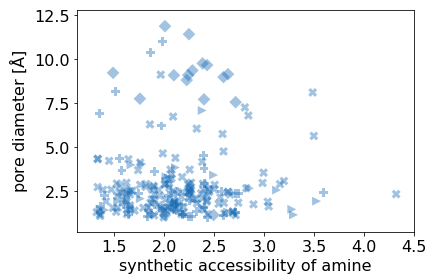

In [212]:
fig, ax = plt.subplots()
for i, row in final_db.iterrows():
    if row.bb1 == 'aldehyde1':
        ax.scatter(row.SA2, row.p_diam_opt, c='#1469b5', alpha=0.4, edgecolor='none', marker=topo_markers[row.topo], s=80)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('synthetic accessibility of amine', fontsize=16)
ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
# ax.set_xlim(-0.5, 13)
# ax.set_ylim(-5, 120)
fig.tight_layout()
fig.savefig(output_dir+"pdiam_VS_SA2.pdf",
            dpi=720, bbox_inches='tight')

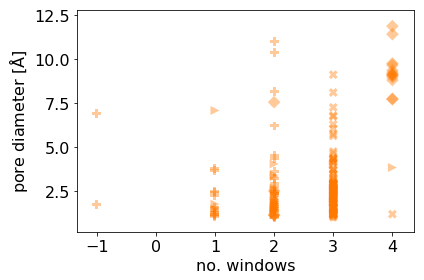

In [209]:
fig, ax = plt.subplots()
for i, row in final_db.iterrows():
    if row.bb1 == 'aldehyde1':
        ax.scatter(row.w_no, row.p_diam_opt, c='#FF7900', alpha=0.4, edgecolor='none', marker=topo_markers[row.topo], s=80)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('no. windows', fontsize=16)
ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
# ax.set_xlim(-0.5, 13)
# ax.set_ylim(-5, 120)
fig.tight_layout()
fig.savefig(output_dir+"pdiam_VS_wn.pdf",
            dpi=720, bbox_inches='tight')

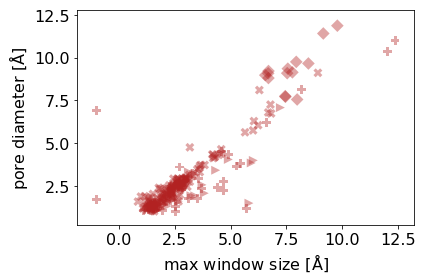

In [211]:
fig, ax = plt.subplots()
for i, row in final_db.iterrows():
    if row.bb1 == 'aldehyde1':
        ax.scatter(row.w_max, row.p_diam_opt, c='firebrick', alpha=0.4, edgecolor='none', marker=topo_markers[row.topo], s=80)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('max window size [$\mathrm{\AA}$]', fontsize=16)
ax.set_ylabel('pore diameter [$\mathrm{\AA}$]', fontsize=16)
# ax.set_xlim(-0.5, 13)
# ax.set_ylim(-5, 120)
fig.tight_layout()
fig.savefig(output_dir+"pdiam_VS_wmax.pdf",
            dpi=720, bbox_inches='tight')